In [45]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

function H_odf(ρ, ϕ, t, zernike_coefficients_even, U, ψ, μ, ω)
    total = 0
    for (i, coeff) in enumerate(zernike_coefficients_even)
        total += coeff * (R(Int64(2*i - 2), 0, ρ)) 
    end
    U * cos(total) 
end

H_odf (generic function with 2 methods)

In [50]:
using Combinatorics
function Z_polynomial(n::Int64)
    """Coefficients for Z_j^0, from low degree to high degree."""
    function summand(k)
        n = big(n)
        k = big(k)
        # The normalization in the front seems right, according to Wikipedia.
        (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int(n/2) - k)*factorial(Int((n)/2) - k))
    end
    res = []
    for i in Array(range(0, stop=Int(n/2), step=1))
        push!(res, summand(i))
    end
    reverse(res)
end
function gaussian_coefficients(n, σ)
    """Integral of a Gaussian against an nth order polynomial from 0 to 1, times 2pi. n must be odd."""
    total = BigFloat(0)
    n = big(n)
    total = 1/2 * σ^2 * doublefactorial(n - 1) * (σ^2/2)^((n-1)/2)
    for i in range(0, Int64((n-1)/2), step = 1)
        total += -1/2 * σ^2 * exp(-1/σ^2) * (σ^2/2)^(i) * doublefactorial(n-1)/doublefactorial(n - 1 - 2 * i)
    end
    2 * π * total
end
function zernike_gaussian_coefficients(σ, m)
    """Try to reconstruct a gaussian, using Zernike polynomials up to order m"""
    coeffs = []
    for n in collect(2 * range(0, m/2, step=1))
        coeff = 0
        for (i, coefficient) in enumerate(Z_polynomial(Int64(n)))
            scalar = (2 * n + 2)/π
            coeff += coefficient/2 * gaussian_coefficients(2 * i - 1, σ) * scalar #/2 because m=0
        end
        push!(coeffs, coeff)
    end
    coeffs
end
function reconstruct_gaussian(ρ, σ, m)
    """Try to reconstruct a gaussian, using Zernike polynomials up to order m"""
    total = BigFloat(0)
    coeffs = zernike_gaussian_coefficients(σ, m)
    for (i, coeff) in enumerate(coeffs)
        total += coeff * (R(Int64(2*i - 2), 0, ρ)) # THIS WAS THE PROBLEM. MAKE SURE YOU'RE DOING THE MATH RIGHT.
    end
    total
end

# The way I was/am reconstructing is b0rked.

reconstruct_gaussian (generic function with 1 method)

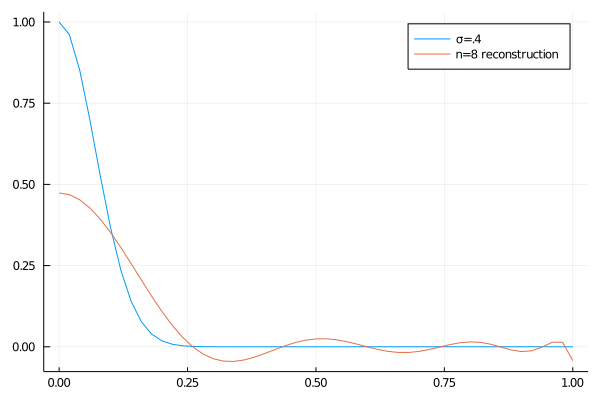

In [53]:
using Plots

# Including too many terms, esp. at high σ, breaks it.
Γ = 1/62
ω = 2*π*180E3
θ = 0.;
σ = .1
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
max_n = 15
evolution_time =  50E-6
U = π/(2*evolution_time)
step_size = evolution_time
T = [0.0:step_size:evolution_time;]
order =  0
μ = order * ω
zernikeeven = zernike_gaussian_coefficients(σ, max_n)



max_ρ = 1
min_ρ = 0
num_samples = 50
ρs = range(min_ρ, max_ρ, step=max_ρ/num_samples)
ys = [reconstruct_gaussian(ρ, σ, max_n) for ρ in ρs];
target = [exp(-ρ^2/σ^2) for ρ in ρs];
display(plot(ρs, [target, ys], labels=["σ=.4" "n=8 reconstruction"]))

In [54]:
function evolution_evaluator_factory(ψ0, T, zernikeeven, U, ψ, μ, ω, b)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, U, ψ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
exact_evolution_evaluator = evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, μ, ω, b)

function gaussian_spin_profile_evaluator(scale)
    function gaussian_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = scale * U * cos(exp(-ρ^2/σ^2)) * sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    _, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
    last(ψ)
    end
end

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

infidelity_across_disk (generic function with 1 method)

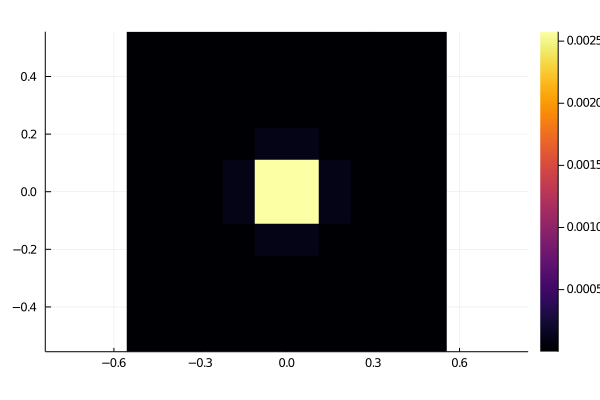

In [55]:
discretization = 10
max_dim = .5
function plot_across_unit_disk(f, discretization)
    x = y = Array(range(-max_dim, max_dim, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end
exact_evolution_evaluator = evolution_evaluator_factory(ψ0, T, zernikeeven, U, θ, μ, ω, b)
plot(heatmap(plot_across_unit_disk(infidelity_across_disk(gaussian_spin_profile_evaluator(1), exact_evolution_evaluator), discretization)), aspectratio = true)